# Обучение на MNIST с помощью PyTorch

### Автор: студент группы BD-21 проекта Техносфера Ракитин Виталий.

## Задание:
    
Повторить обучение на mnist из прошлой домашки:
 	
Используя структуру сети Sequental в pytorch реализовать и обучить классификатор цифр из MNIST

1. Количество слоев от 1 до 4
2. Разные размеры скрытых слоев: 5, 10, 50, 100, 300
3. С разными функциями активации (без, ReLU, sigmoid, tanh)
4. С разными функциями потерь (CrossEntropy, MSE, NLL)
5. Со смещениями и без.

Каждый пункт 2-3 варианта.

Результат в форме отчета: скорость и качество обучения от параметров сети.
Везде где имеет смысл нарисовать графики.



### 0. Загрузим MNIST

In [1]:
from sklearn.datasets import fetch_mldata
import sklearn.cross_validation as cv
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.metrics import classification_report

import matplotlib.pyplot as pl
from timeit import default_timer as timer  

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
mnist = fetch_mldata('MNIST original')
train_data, test_data, train_target, test_target =\
            cv.train_test_split(mnist.data, mnist.target, test_size=0.30, random_state=42)
    
nn = torch.nn

In [3]:
def create_y(y):
    new_y = np.zeros((y.shape[0], 10))
    for i in xrange(y.shape[0]):
        new_y[i][int(y[i])] = 1
    return new_y

    
def create_var( train_data, 
                test_data, 
                train_target, 
                test_target
               ):
    test_target_new = create_y(test_target)
    train_target_new = create_y(train_target)
    X_train = Variable(torch.from_numpy(train_data).type(torch.FloatTensor), requires_grad=False)
    Y_train = Variable(torch.from_numpy(train_target).type(torch.LongTensor), requires_grad=False)
    Y_train_wide = Variable(torch.from_numpy(train_target_new).type(torch.FloatTensor), requires_grad=False)
    X_test = Variable(torch.from_numpy(test_data).type(torch.FloatTensor), requires_grad=False)
    Y_test = Variable(torch.from_numpy(test_target).type(torch.LongTensor), requires_grad=False)
    Y_test_wide = Variable(torch.from_numpy(train_target_new).type(torch.FloatTensor), requires_grad=False)

    return X_train, Y_train, Y_train_wide, X_test, Y_test, Y_test_wide

In [4]:
x_tr,y_tr,y_tr_w,x_tt,y_tt,y_tt_w = create_var(train_data, test_data, train_target, test_target)

## 1. Система для обучения и тестирования 

In [5]:
class NeuNet():
    def __init__(self, 
                 layers, 
                 loss_func = nn.MSELoss(size_average=True),
                 optimizer = torch.optim.Adam,
                 opt_learning_rate = 1e-5,
                 min_loss_dist = 1e-20,
                ):
        '''
        >>> layers --- list of dicts: {"name" : ModuleName, "module" : Module}
        >>> Loss --- loss function
        '''
        self.loss_func = loss_func
        self.model = nn.Sequential()
        for layer in layers:
            self.model.add_module(layer["name"], layer["module"])
            
        self.optimizer = optimizer(self.model.parameters(), lr = opt_learning_rate)
        self.min_loss_dist = min_loss_dist
        self.losses = []
    
    def timer(func):
        def wrapper(*args, **kwargs):
            start = timer()
            result = func(*args, **kwargs)
            end = timer()
            print("Calculation time: {} sec.".format(end - start))
            return result
        return wrapper
    
    @timer    
    def train(self,
              data, 
              target, 
              max_iter_item = 50, 
              batch_size = 40):
        ''' 
        >>> train until the loss function stabilizes 
        '''
        counter = 0
        loss_pred = 1000 * self.min_loss_dist
        loss_diff = 1000 * self.min_loss_dist
        batches_number = len(data) / batch_size

        data_batch = [data[i * batch_size : (i+1) * batch_size] for i in xrange(batches_number)]
        target_batch = [target[i * batch_size : (i+1) * batch_size] for i in xrange(batches_number)]
        
        while  counter < max_iter_item and abs(loss_diff) > self.min_loss_dist:
            
            for i,X in enumerate(data_batch):
                Y = target_batch[i]
                target_pred = self.model(X)
                loss = self.loss_func(target_pred, Y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                         
            target_pred = self.model(data)
            loss = self.loss_func(target_pred, target)
            loss_diff = loss_pred - loss.data[0] 
            loss_pred = loss.data[0]
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.data[0])
            counter += 1   

    def test(self, data, target, title = None):
        print "________________________________________"
        target_pred = self.model.forward(data)
        res, ind = torch.max(self.model.forward(data),1)
        self.sk_report(ind, target, title)
        distance = (ind - target).data.numpy()
        k = np.array([1 if abs(res.sum()) < 0.5 else 0 for res in distance])
        print "{0} of {1} items identified correctly on {2}.".format(sum(k),len(k), title)
        print "________________________________________"
        
    
    def plot(self,
             x, y,
             title = "Plot",
             xlabel = None,
             ylabel = None,
             axis  = None,
             grid  = True,
             save = False,
             name  = "plot.png",
            ):
        
        pl.plot(x,y)
        pl.ylabel(ylabel)
        pl.xlabel(xlabel)
        pl.title(title)   
        pl.grid(grid)
        if axis:
            pl.axis(axis)      
        if save:
            pl.savefig(name)
        pl.show()
        print "show"
        pl.close()
        return self
    
    def losses_plot(self):
        steps = [i for i in xrange(len(self.losses))]
        self.plot(steps, self.losses, title = "Losses", xlabel = "steps", ylabel = "Losses on steps")
        
    def sk_report(self, ind, target, title = None):
        if title:
            print "Sklearn classification report of " + title
        else:
            print "Sklearn classification report"
        
        print classification_report(np.array(target.data.tolist()), np.array(ind.data.tolist()))
    
    def report(self, data_train, target_train, data_test, target_test):
        self.test(data_train, target_train, "train sample")
        self.test(data_test, target_test, "test sample")
        self.losses_plot()
        

# 3. Протестируем различные модели

## Однослойная модель без функции активации

Calculation time: 47.1426129341 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.94      0.98      0.96      4890
          1       0.96      0.96      0.96      5557
          2       0.90      0.87      0.89      4850
          3       0.84      0.89      0.86      5043
          4       0.92      0.91      0.91      4777
          5       0.86      0.83      0.84      4342
          6       0.94      0.94      0.94      4784
          7       0.93      0.91      0.92      5087
          8       0.84      0.82      0.83      4773
          9       0.86      0.88      0.87      4897

avg / total       0.90      0.90      0.90     49000

44064 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

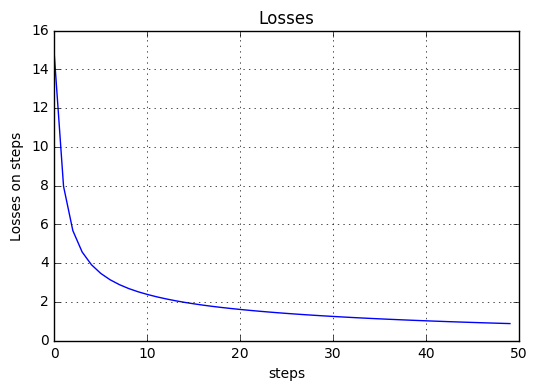

show


In [6]:
D_in_1 = int(x_tr.size()[1])
D_out_1 = 10
layer_1 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)}]
        
model_1 = NeuNet(layer_1, loss_func = nn.CrossEntropyLoss())
model_1.train(x_tr, y_tr)
model_1.report(x_tr, y_tr, x_tt, y_tt)

Видно, что значение функции потерь постепенно выходит на константу. Даже на такой простой модели результаты получились неплохие.

А что будет если убрать смещение (bais) из данной модели?

## Однослойная модель без смещения

Calculation time: 43.5873491764 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      4890
          1       0.96      0.96      0.96      5557
          2       0.91      0.87      0.89      4850
          3       0.83      0.90      0.86      5043
          4       0.91      0.91      0.91      4777
          5       0.84      0.84      0.84      4342
          6       0.94      0.94      0.94      4784
          7       0.93      0.89      0.91      5087
          8       0.84      0.80      0.82      4773
          9       0.85      0.88      0.86      4897

avg / total       0.90      0.90      0.90     49000

43966 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

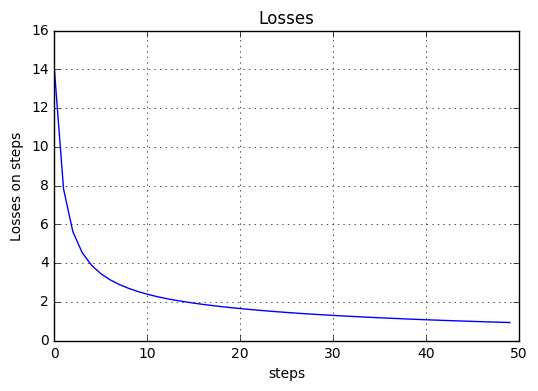

show


In [7]:
D_in_2 = int(x_tr.size()[1])
D_out_2 = 10
layer_2 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1, bias = False)}]
        
model_2 = NeuNet(layer_2, loss_func = nn.CrossEntropyLoss())
model_2.train(x_tr, y_tr)
model_2.report(x_tr, y_tr, x_tt, y_tt)

Результаты получились немного хуже, но разница незначительна (1%). Однако, заметно уменьшение скорости обучения на 8%. 

Попробуем добавить функцию активации.

## Однослойная модель с функцией активации - сигмоидой.

Calculation time: 50.8859930038 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.94      0.97      0.95      4890
          1       0.95      0.96      0.96      5557
          2       0.86      0.89      0.87      4850
          3       0.79      0.86      0.83      5043
          4       0.86      0.92      0.89      4777
          5       0.85      0.72      0.78      4342
          6       0.94      0.92      0.93      4784
          7       0.92      0.90      0.91      5087
          8       0.85      0.83      0.84      4773
          9       0.88      0.85      0.86      4897

avg / total       0.88      0.88      0.88     49000

43324 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

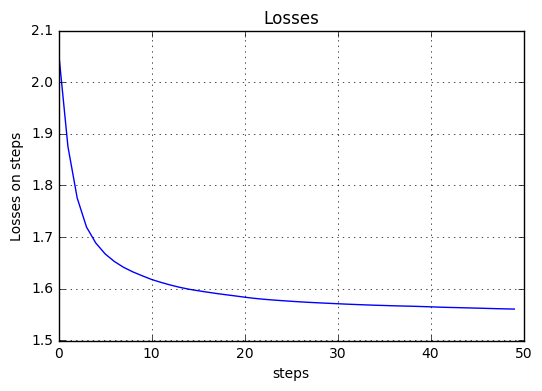

show


In [8]:
D_in_3 = int(x_tr.size()[1])
D_out_3 = 10
layer_3 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)},
           {"name": "sigmoid", "module": nn.Sigmoid()}]
        
model_3 = NeuNet(layer_3, loss_func = nn.CrossEntropyLoss())
model_3.train(x_tr, y_tr)
model_3.report(x_tr, y_tr, x_tt, y_tt)

Результаты получились немного хуже, чем без функции активации, но ухудшение незначительно (1-2%).

## Однослойная модель с функциями активации - Relu, LogSoftMax

Calculation time: 57.8000998497 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.14      1.00      0.25      4890
          1       0.99      0.91      0.95      5557
          2       0.00      0.00      0.00      4850
          3       0.92      0.35      0.51      5043
          4       0.00      0.00      0.00      4777
          5       1.00      0.00      0.00      4342
          6       0.98      0.79      0.88      4784
          7       0.98      0.81      0.89      5087
          8       0.00      0.00      0.00      4773
          9       0.85      0.02      0.04      4897

avg / total       0.59      0.40      0.37     49000

19745 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

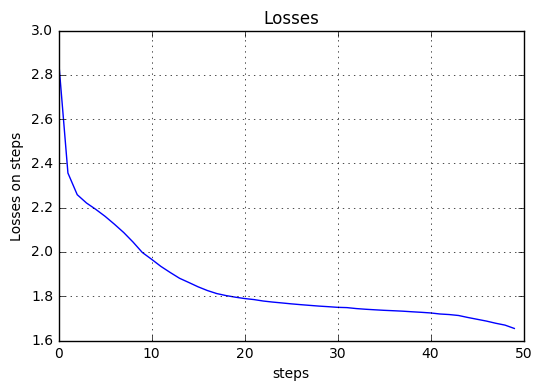

show


In [22]:
D_in_41 = int(x_tr.size()[1])
D_out_41 = 10
layer_41 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)},
           {"name": "Relu", "module": nn.ReLU()}]
        
model_41 = NeuNet(layer_41, loss_func = nn.CrossEntropyLoss())
model_41.train(x_tr, y_tr)
model_41.report(x_tr, y_tr, x_tt, y_tt)

Calculation time: 46.8785688877 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      4890
          1       0.95      0.97      0.96      5557
          2       0.91      0.85      0.88      4850
          3       0.86      0.88      0.87      5043
          4       0.91      0.91      0.91      4777
          5       0.85      0.85      0.85      4342
          6       0.95      0.94      0.94      4784
          7       0.92      0.91      0.92      5087
          8       0.82      0.83      0.83      4773
          9       0.86      0.88      0.87      4897

avg / total       0.90      0.90      0.90     49000

44098 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

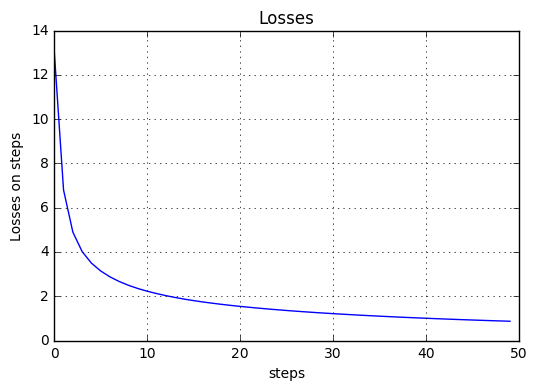

show


In [28]:
D_in_43 = int(x_tr.size()[1])
D_out_43 = 10
layer_43 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)},
            {"name":"LSM", "module":torch.nn.LogSoftmax()}]
        
model_43 = NeuNet(layer_43, loss_func = nn.NLLLoss(size_average=True))
model_43.train(x_tr, y_tr)
model_43.report(x_tr, y_tr, x_tt, y_tt)

Calculation time: 21.175137043 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.10      1.00      0.18      4890
          1       0.00      0.00      0.00      5557
          2       0.00      0.00      0.00      4850
          3       0.00      0.00      0.00      5043
          4       0.00      0.00      0.00      4777
          5       0.00      0.00      0.00      4342
          6       0.00      0.00      0.00      4784
          7       0.00      0.00      0.00      5087
          8       0.00      0.00      0.00      4773
          9       0.00      0.00      0.00      4897

avg / total       0.01      0.10      0.02     49000

4890 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   support


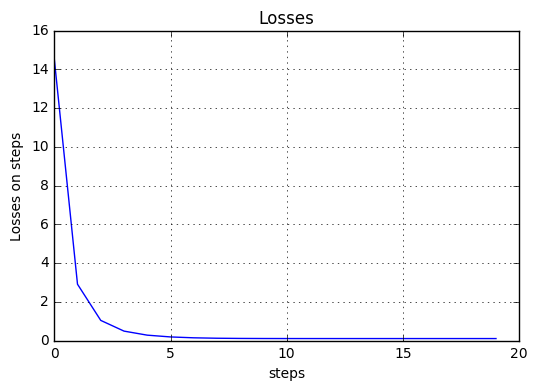

show


In [36]:
D_in_43 = int(x_tr.size()[1])
D_out_43 = 10
layer_43 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)},
            {"name":"LSM", "module": nn.ReLU()}]
        
model_43 = NeuNet(layer_43, loss_func = nn.MSELoss(size_average=True))
model_43.train(x_tr, y_tr_w)
model_43.report(x_tr, y_tr, x_tt, y_tt)

## Однослойная модель с функцией активации - Tanh.

Calculation time: 39.49061203 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.72      0.98      0.83      4890
          1       0.93      0.96      0.95      5557
          2       0.87      0.87      0.87      4850
          3       0.82      0.84      0.83      5043
          4       0.88      0.90      0.89      4777
          5       0.88      0.70      0.78      4342
          6       0.94      0.89      0.91      4784
          7       0.93      0.89      0.91      5087
          8       0.85      0.74      0.79      4773
          9       0.89      0.84      0.87      4897

avg / total       0.87      0.87      0.86     49000

42392 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   support


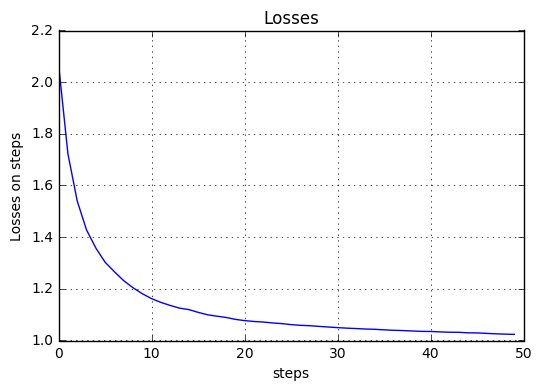

show


In [13]:
D_in_5 = int(x_tr.size()[1])
D_out_5 = 10
layer_5 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_out_1)},
           {"name": "Tanh", "module": nn.Tanh()}]
 
model_5 = NeuNet(layer_5, loss_func = nn.CrossEntropyLoss())
model_5.train(x_tr, y_tr)
model_5.report(x_tr, y_tr, x_tt, y_tt)

Значение функции потерь получилось наименьшим, однако качество классификации стало незначительно хуже. Заметно улучшилось время расчёта (на 16% относительно простой однослойной модели без функции активации)

## Двуслойная модель

Calculation time: 56.1569321156 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.86      0.94      0.90      4890
          1       0.92      0.95      0.93      5557
          2       0.85      0.80      0.82      4850
          3       0.66      0.86      0.74      5043
          4       0.89      0.80      0.85      4777
          5       0.79      0.48      0.60      4342
          6       0.80      0.90      0.85      4784
          7       0.79      0.91      0.85      5087
          8       0.73      0.60      0.66      4773
          9       0.80      0.74      0.77      4897

avg / total       0.81      0.81      0.80     49000

39462 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

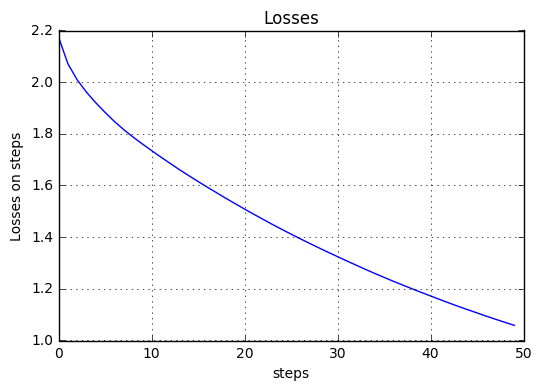

show


In [14]:
D_in_6 = int(x_tr.size()[1])
D_hidden = 10
D_out_6 = 10
layer_6 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden, D_out_1)}]
        
model_6 = NeuNet(layer_6, loss_func = nn.CrossEntropyLoss())
model_6.train(x_tr, y_tr)
model_6.report(x_tr, y_tr, x_tt, y_tt)

Calculation time: 127.598804951 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      4890
          1       0.96      0.97      0.97      5557
          2       0.93      0.91      0.92      4850
          3       0.91      0.90      0.91      5043
          4       0.93      0.94      0.94      4777
          5       0.89      0.88      0.88      4342
          6       0.95      0.96      0.95      4784
          7       0.94      0.94      0.94      5087
          8       0.89      0.87      0.88      4773
          9       0.91      0.90      0.91      4897

avg / total       0.93      0.93      0.93     49000

45415 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

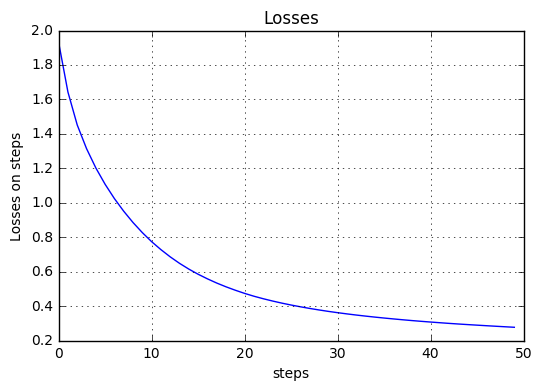

show


In [15]:
D_in_7 = int(x_tr.size()[1])
D_hidden = 50
D_out_7 = 10
layer_7 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden, D_out_1)}]
        
model_7 = NeuNet(layer_7, loss_func = nn.CrossEntropyLoss())
model_7.train(x_tr, y_tr)
model_7.report(x_tr, y_tr, x_tt, y_tt)

Calculation time: 210.30926013 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.97      0.98      0.97      4890
          1       0.98      0.98      0.98      5557
          2       0.94      0.92      0.93      4850
          3       0.93      0.92      0.93      5043
          4       0.94      0.96      0.95      4777
          5       0.92      0.91      0.91      4342
          6       0.96      0.97      0.96      4784
          7       0.96      0.96      0.96      5087
          8       0.91      0.91      0.91      4773
          9       0.94      0.93      0.94      4897

avg / total       0.94      0.94      0.94     49000

46305 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   support

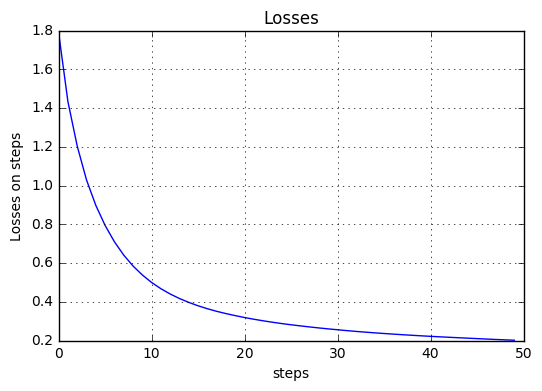

show


In [16]:
D_in_8 = int(x_tr.size()[1])
D_hidden = 100
D_out_8 = 10
layer_8 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden, D_out_1)}]
        
model_8 = NeuNet(layer_8, loss_func = nn.CrossEntropyLoss())
model_8.train(x_tr, y_tr)
model_8.report(x_tr, y_tr, x_tt, y_tt)

Заметно, что двуслойные модели работают значительно медленнее однослойных. При малом количестве параметров, результаты получаются не лучше, чем в однослойных моделях. Однако, качество классификации растёт при увеличении количества нейронов в скрытом слое.

## Трёхслойная модель

Calculation time: 301.921505928 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      4890
          1       0.98      0.98      0.98      5557
          2       0.95      0.94      0.95      4850
          3       0.94      0.93      0.94      5043
          4       0.95      0.97      0.96      4777
          5       0.93      0.94      0.93      4342
          6       0.97      0.98      0.97      4784
          7       0.96      0.96      0.96      5087
          8       0.94      0.93      0.94      4773
          9       0.95      0.94      0.95      4897

avg / total       0.96      0.96      0.96     49000

46864 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

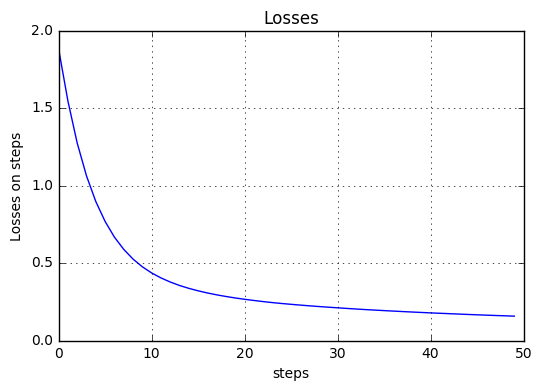

show


In [32]:
D_in_9 = int(x_tr.size()[1])
D_hidden1 = 100
D_hidden2 = 50
D_out_9 = 10
layer_9 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden1)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden1, D_hidden2)},
           {"name": "Tanh", "module": nn.Tanh()},
           {"name":"Linear2", "module": nn.Linear(D_hidden2, D_out_1)},
           {"name":"LSM", "module": nn.LogSoftmax()}]
        
model_9 = NeuNet(layer_9, loss_func = nn.CrossEntropyLoss())
model_9.train(x_tr, y_tr)
model_9.report(x_tr, y_tr, x_tt, y_tt)

Результаты продолжают улучшаться, однако видно, что функция потерь не успела выйти на константу.

## Четырёхслойная модель

Calculation time: 295.202709198 sec.
________________________________________
Sklearn classification report of train sample
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      4890
          1       0.98      0.98      0.98      5557
          2       0.94      0.94      0.94      4850
          3       0.93      0.93      0.93      5043
          4       0.95      0.97      0.96      4777
          5       0.93      0.92      0.93      4342
          6       0.96      0.98      0.97      4784
          7       0.96      0.96      0.96      5087
          8       0.94      0.93      0.93      4773
          9       0.95      0.94      0.94      4897

avg / total       0.95      0.95      0.95     49000

46702 of 49000 items identified correctly on train sample.
________________________________________
________________________________________
Sklearn classification report of test sample
             precision    recall  f1-score   suppor

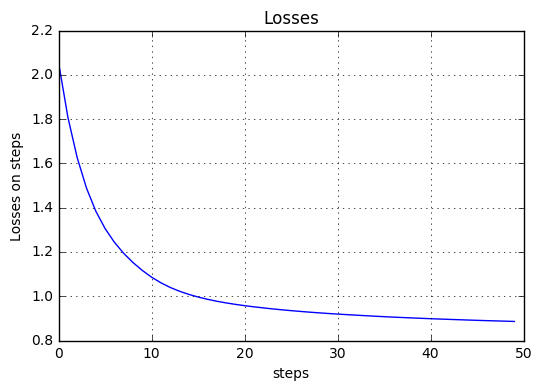

show


In [33]:
D_in_10 = int(x_tr.size()[1])
D_hidden1 = 100
D_hidden2 = 50
D_hidden3 = 50
D_out_10 = 10
layer_10 = [{"name":"Linear", "module": nn.Linear(D_in_1, D_hidden1)},
           {"name": "sigmoid", "module": nn.Sigmoid()},
           {"name":"Linear1", "module": nn.Linear(D_hidden1, D_hidden2)},
           {"name": "Tanh", "module": nn.Tanh()},
           {"name":"Linear2", "module": nn.Linear(D_hidden2, D_hidden3)},
           {"name":"LSM", "module": nn.LogSoftmax()},
           {"name":"Linear3", "module": nn.Linear(D_hidden3, D_out_1)},
           {"name":"tanh2", "module": nn.Tanh()}]
        
model_10 = NeuNet(layer_10, loss_func = nn.CrossEntropyLoss())
model_10.train(x_tr, y_tr)
model_10.report(x_tr, y_tr, x_tt, y_tt)

Очевидно, что при увеличении количества слоёв увеличивется время обучения, однако качество принципиально не меняется. Таким образом наиболее оптимальной является 2х слойная модель.